# Prelim ARIMA Retro. Analysis

## notes

###### **pageviews only:**

- pick pageid(s)
- get daily views series for 2 years
- regress pageviews ~ weekends, holidays, linear trend:
    - get residuals RS_VIEWS
- lag RS_VIEWS to get RS_VIEWS_L!, L2, etc.
- regress RS_VIEWS on:
    - a naive moving average of RS_VIEWS lags
    - and some AR lags of RS_VIEWS
- do ARIMA analysis of pageviews to compare

#### later

###### **edits only:**

same thing

###### **pageviews and edits:**

- regress RS_EDITS on RS_VIEWS_L1
- regress RS_EDITS on RS_EDITS_LX and RS_VIEWS_LX

## setup

#### initial

##### imports

In [4]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
import os

##### mariadb

###### pass

###### connect

#### get and clean data

##### get edits, views

###### paths

In [5]:
jawiki_path = '../data/processed/jawiki/'

###### get and clean edits

In [6]:
# get edits
edits = pd.read_csv(f'{jawiki_path}disaster_allpageids_daily_edits.tsv', 
                 sep='\t', usecols=['day', 'page_id', 'edits'])
# create multiindex
edits.set_index(['day', 'page_id'], inplace=True)
# pivot multiindex wide and replace NaN with 0
edits = edits.unstack().fillna(0)
# drop a vestigial multiindex (non-informative)
edits.columns = edits.columns.droplevel(0)
# sort columns
edits.sort_index(axis=1, inplace=True)
# convert date-string index to DatetimeIndex
edits.index = pd.DatetimeIndex(edits.index)

###### get and clean views

In [7]:
dfs = []
# Do all files in folder. Each file is a year.
for i in os.listdir(f'{jawiki_path}views/'): 
    # read csv
    df = pd.read_csv(f'{jawiki_path}views/{i}', sep=',')
    # parse date, drop unparsed date, set date as index
    df['date'] = pd.to_datetime(df['Unnamed: 0'], format='%Y%m%d')
    df.drop(columns='Unnamed: 0', inplace=True)
    df.set_index('date', inplace=True, drop=True)
    # create multiindex for columns
    df_columns = df.columns.str.split('_', expand=True)
    # df_columns[]
    df.columns = df_columns
    # sort multiindex (maybe unnecessary, but clarifies process)
    df.sort_index(axis=1, inplace=True)
    # aggregate (sum) pageviews from different platforms (mobile/desktop)
    df = df.groupby(axis=1, level=0).sum()
    # convert column-index to integers
    df.columns = df.columns.astype(int)
    # append to list
    dfs.append(df)

views = pd.concat(dfs, axis=0).fillna(0)
del dfs, df, df_columns

# edits[edits.page_id.apply(lambda x: x in busy_pageids)]

##### clean and interact edits, views

###### drop the years in edits where I don't have pageviews data yet

In [8]:
edits = edits[edits.index >= min(views.index)]
edits = edits[edits.index <= max(views.index)]

###### drop the outersection of pageids between views & edits

In [9]:
intersection_pageids = set(edits.columns).intersection(set(views.columns))

In [10]:
edits.shape, views.shape

((1096, 18185), (1096, 14555))

In [11]:
edits = edits[intersection_pageids]
views = views[intersection_pageids]

###### check for dates where there were no edits recorded (there are none)

In [12]:
date_range = pd.date_range(min(views.index), max(views.index))

In [13]:
set(views.index).difference(edits.index)

# edits = edits.reindex(date_range)
# views = views.reindex(date_range)

# views.isna().sum(axis=1).sort_values()
# edits.isna().sum(axis=1).sort_values()

set()

#### filter to shortlist of pageids:  (edits_busy, views_busy)

In [50]:
edit_freq = (edits > 0).sum(axis=0).sort_values(ascending=False)
busy_pageids = edit_freq[edit_freq>100].index.to_list() # 203 busy_pageids
e = edits[busy_pageids]
v = views[busy_pageids]
del edit_freq

## EDA

In [14]:
edits.shape, views.shape

((1096, 14432), (1096, 14432))

##### viz distributions

###### days where there was at least one edit (compared with days with at least one view) across articles

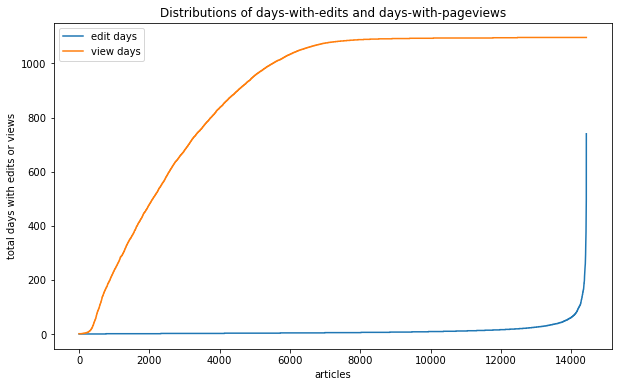

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1)
(edits > 0).sum(axis=0).sort_values().reset_index(drop=True).rename('edit days').plot(figsize=(10,6), ax=ax)
(views > 0).sum(axis=0).sort_values().reset_index(drop=True).rename('view days').plot(figsize=(10,6), ax=ax)
# views.
# ax.set_yscale('log')
ax.set_ylabel('total days with edits or views')
ax.set_xlabel('articles')
ax.set_title('Distributions of days-with-edits and days-with-pageviews')
ax.legend()
plt.show()

###### total edits compared to total views across articles

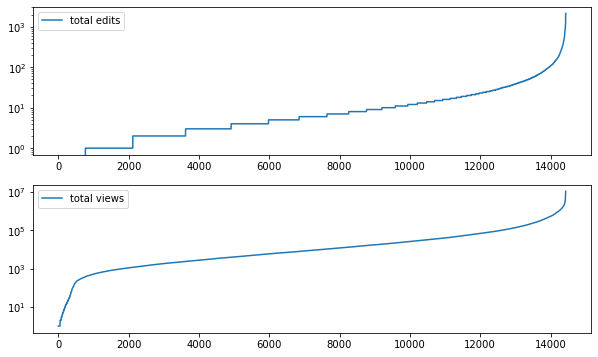

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=1)
edits.sum(axis=0).sort_values().reset_index(drop=True).rename('total edits').plot(figsize=(10,6), ax=axes[0])
views.sum(axis=0).sort_values().reset_index(drop=True).rename('total views').plot(figsize=(10,6), ax=axes[1])
for ax in axes:    
    ax.legend()
    ax.set_yscale('log')

plt.show()

## model

In [54]:
e.columns

Int64Index([2062156, 3386415, 3293162, 3301755, 2852452, 1529557,  719740,
            1862799, 1986518, 2345302,
            ...
            3565966, 3504755, 1581400, 3089084,   42861,  443586,   16042,
            1875030, 2368599, 2937710],
           dtype='int64', name='page_id', length=203)

In [55]:
v.columns

Int64Index([2062156, 3386415, 3293162, 3301755, 2852452, 1529557,  719740,
            1862799, 1986518, 2345302,
            ...
            3565966, 3504755, 1581400, 3089084,   42861,  443586,   16042,
            1875030, 2368599, 2937710],
           dtype='int64', length=203)